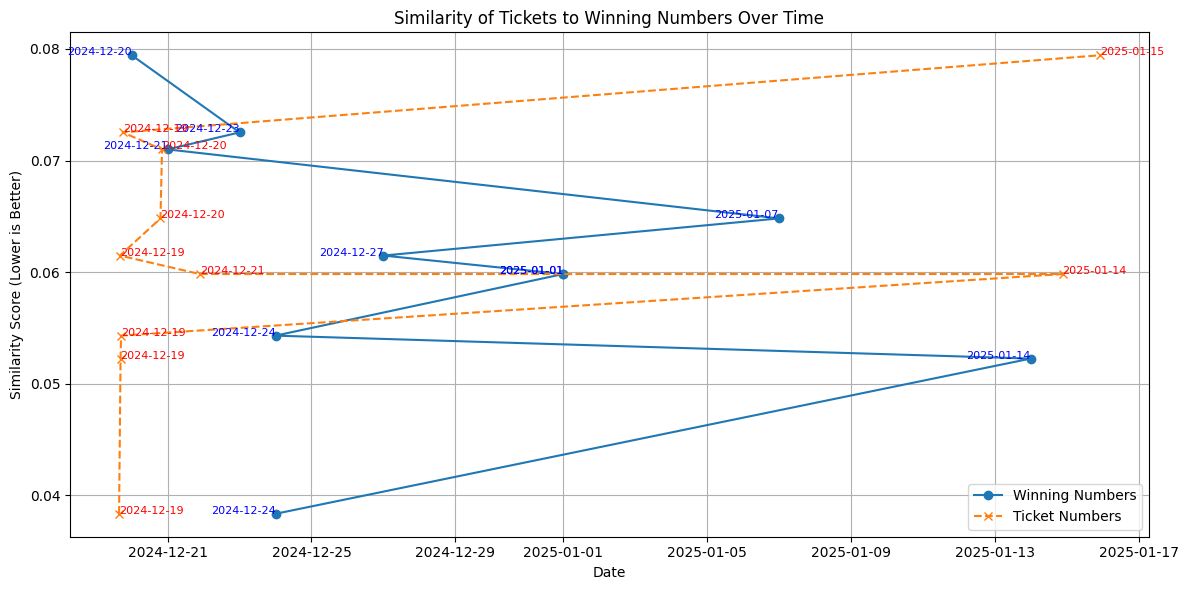

In [4]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# SQL query to compare all winning numbers with tickets
query = """
SELECT 
    wn.id AS winning_id,
    pts.id AS ticket_id,
    wn.white_ball_1, wn.white_ball_2, wn.white_ball_3, wn.white_ball_4, wn.white_ball_5, wn.powerball AS winning_powerball,
    pts.white_ball_1, pts.white_ball_2, pts.white_ball_3, pts.white_ball_4, pts.white_ball_5, pts.powerball AS ticket_powerball,
    wn.draw_date,
    pts.generated_at,
    wn.source AS winning_source,
    pts.source AS ticket_source,
    pts.embedding <-> ARRAY[
        wn.white_ball_1 / 69.0,
        wn.white_ball_2 / 69.0,
        wn.white_ball_3 / 69.0,
        wn.white_ball_4 / 69.0,
        wn.white_ball_5 / 69.0,
        wn.powerball / 26.0
    ]::vector AS similarity
FROM 
    winning_numbers wn
JOIN 
    powerball_ticket_sessions pts
ON 
    TRUE
ORDER BY 
    similarity ASC
LIMIT 10;
"""

def fetch_comparison_data():
    try:
        # Connect to PostgreSQL
        conn = psycopg2.connect(
            dbname="rag_db",
            user="user",
            password="password",
            host="192.168.0.34",
            port=5432
        )
        cursor = conn.cursor()

        # Execute the query
        cursor.execute(query)
        results = cursor.fetchall()

        # Convert results into a DataFrame
        columns = [
            "winning_id", "ticket_id",
            "winning_white_1", "winning_white_2", "winning_white_3", "winning_white_4", "winning_white_5", "winning_powerball",
            "ticket_white_1", "ticket_white_2", "ticket_white_3", "ticket_white_4", "ticket_white_5", "ticket_powerball",
            "winning_date", "ticket_date", "winning_source", "ticket_source", "similarity"
        ]
        df = pd.DataFrame(results, columns=columns)
        return df

    except Exception as e:
        print(f"Database error: {e}")
        return None
    finally:
        cursor.close()
        conn.close()

def plot_comparison_chart(df):
    """
    Plot a comparison chart showing the similarity of the closest tickets to the winning numbers, with their respective dates.
    """
    # Extract similarity scores and dates
    similarities = df['similarity']
    winning_dates = pd.to_datetime(df['winning_date'])
    ticket_dates = pd.to_datetime(df['ticket_date'])

    # Plot the similarity scores
    plt.figure(figsize=(12, 6))
    plt.plot(winning_dates, similarities, marker='o', label='Winning Numbers')
    plt.plot(ticket_dates, similarities, marker='x', label='Ticket Numbers', linestyle='--')

    # Annotate the dates
    for i, (win_date, ticket_date, sim) in enumerate(zip(winning_dates, ticket_dates, similarities)):
        plt.text(win_date, sim, f"{win_date.date()}", fontsize=8, color='blue', ha='right')
        plt.text(ticket_date, sim, f"{ticket_date.date()}", fontsize=8, color='red', ha='left')

    # Customize the chart
    plt.title('Similarity of Tickets to Winning Numbers Over Time')
    plt.xlabel('Date')
    plt.ylabel('Similarity Score (Lower is Better)')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Show the chart
    plt.show()

# Fetch data and plot the chart
comparison_data = fetch_comparison_data()
if comparison_data is not None:
    plot_comparison_chart(comparison_data)
